<a href="https://colab.research.google.com/github/ale1995co/Final-Capstone/blob/master/Baseline%26KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Anime Recommender System

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd 
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as py
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')


In this notebook presents a solution for a recommender system for the MyAnimeList portal. MyAnimeList.net is a platform where people can rate their anime and score them 1-10. One improvement that can help the website is to have some kind of reccomendation system. This notebook will provide a user-based and an item-based collaborative filtering system.

# Context 

MyAnimeList website is like a IMDB of Japanese content. Essentially Anime is Japanese animation. I'm an avid fan of Anime. I thought this would be a good final capstone and help suggest new anime for myself would be a neat idea. 

Couple of companies like Netflix and Spotify use recommendation system all the time. There are many ways to build a reccomendation system. 

# Datasets


The datasets I will use came from azazoth42.(https://www.kaggle.com/azathoth42/myanimelist). He did alot of the dirty work by websraping the data from myanimelist.net. There are three CSVs that I'm going to use.

The datasets are mainly divided in three. One with info about the MyAnimeList customers (df_users) such as location, gender, birth date and so on. Another one for info about the anime, which brings data like the title of the show, what genre is it inside and even the opening themes. The last one (and also the biggest one) is all the scores that a certain user had with a show (that have 31M rows of interactions.

# Load Data

In [0]:
df_users = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Final Capstone/users_filtered.csv')
df_anime = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Final Capstone/anime_filtered.csv')
df_userlists = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Colab Datasets/Final Capstone/animelists_filtered.csv')


# Data Exploration

In [4]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14474 entries, 0 to 14473
Data columns (total 31 columns):
anime_id          14474 non-null int64
title             14474 non-null object
title_english     5723 non-null object
title_japanese    14440 non-null object
title_synonyms    8936 non-null object
image_url         14378 non-null object
type              14474 non-null object
source            14474 non-null object
episodes          14474 non-null int64
status            14474 non-null object
airing            14474 non-null bool
aired_string      14474 non-null object
aired             14474 non-null object
duration          14474 non-null object
rating            14474 non-null object
score             14474 non-null float64
scored_by         14474 non-null int64
rank              12901 non-null float64
popularity        14474 non-null int64
members           14474 non-null int64
favorites         14474 non-null int64
background        1057 non-null object
premiered         40

There are 14474 unique animes

In [5]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116133 entries, 0 to 116132
Data columns (total 17 columns):
username                    116132 non-null object
user_id                     116133 non-null int64
user_watching               116133 non-null int64
user_completed              116133 non-null int64
user_onhold                 116133 non-null int64
user_dropped                116133 non-null int64
user_plantowatch            116133 non-null int64
user_days_spent_watching    116133 non-null float64
gender                      116133 non-null object
location                    116127 non-null object
birth_date                  116133 non-null object
access_rank                 0 non-null float64
join_date                   116133 non-null object
last_online                 116133 non-null object
stats_mean_score            116133 non-null float64
stats_rewatched             116133 non-null float64
stats_episodes              116133 non-null float64
dtypes: float64(5), int64(6)

There are 116132 unique users

In [6]:
df_userlists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35802006 entries, 0 to 35802005
Data columns (total 11 columns):
username               object
anime_id               int64
my_watched_episodes    int64
my_start_date          object
my_finish_date         object
my_score               int64
my_status              int64
my_rewatching          float64
my_rewatching_ep       int64
my_last_updated        int64
my_tags                object
dtypes: float64(1), int64(6), object(4)
memory usage: 2.9+ GB


There are 35,802,006 ratings in the website. 

In [7]:
df_anime.head(3)

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,False,"Jan 13, 2012 to Mar 30, 2012","{'from': '2012-01-13', 'to': '2012-03-30'}",24 min. per ep.,PG-13 - Teens 13 or older,7.63,139250,1274.0,231,283882,2809,Inu x Boku SS was licensed by Sentai Filmworks...,Winter 2012,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ..."
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,False,"Apr 2, 2007 to Oct 1, 2007","{'from': '2007-04-02', 'to': '2007-10-01'}",24 min. per ep.,PG-13 - Teens 13 or older,7.89,91206,727.0,366,204003,2579,NaN,Spring 2007,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi..."
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,False,"Oct 4, 2008 to Sep 25, 2009","{'from': '2008-10-04', 'to': '2009-09-25'}",24 min. per ep.,PG - Children,7.55,37129,1508.0,1173,70127,802,NaN,Fall 2008,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ..."


In [8]:
df_users.head(3)

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.31,Female,"Chennai, India",1990-04-29,NaN,2013-03-03,2014-02-04 01:32:00,7.43,0.0,3391.0
1,RedvelvetDaisuki,1897606,61,396,39,0,206,118.07,Female,Manila,1995-01-01,NaN,2012-12-13,1900-05-13 02:47:00,6.78,80.0,7094.0
2,Damonashu,37326,45,195,27,25,59,83.70,Male,"Detroit,Michigan",1991-08-01,NaN,2008-02-13,1900-03-24 12:48:00,6.15,6.0,4936.0


In [9]:
df_userlists.head(3)

,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,1362307973,NaN
1,RedvelvetDaisuki,21,0,0000-00-00,0000-00-00,0,3,0.0,0,1355480701,NaN
2,Damonashu,21,418,0000-00-00,0000-00-00,10,1,0.0,0,1254296345,NaN


In [73]:
# merging the df_anime and df_users. So we get the ratings for each anime.
anime = df_anime[df_anime.genre.notnull()][['anime_id','title','type','source','score','scored_by','rank','popularity','genre']]
users = df_users[df_users.gender.isin(['Female','Male'])][['username','gender','user_completed','user_days_spent_watching','birth_date' ]]
userlists = df_userlists[df_userlists.my_status.isin([1,2]) & df_userlists.anime_id.notnull()][['username', 'anime_id', 'my_score', ]]

userlists = pd.merge(userlists,users, how='inner')
userlists = pd.merge(userlists,anime, how='left')

userlists_sub = userlists[userlists.genre.notnull()].head(100000)
userlists_sub.head()

,username,anime_id,my_score,gender,user_completed,user_days_spent_watching,birth_date,title,type,source,score,scored_by,rank,popularity,genre
0,karthiga,21,9,Female,49,55.31,1990-04-29,One Piece,TV,Manga,8.54,423868.0,91.0,35.0,"Action, Adventure, Comedy, Super Power, Drama,..."
1,karthiga,59,7,Female,49,55.31,1990-04-29,Chobits,TV,Manga,7.53,175388.0,1546.0,188.0,"Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen"
2,karthiga,74,7,Female,49,55.31,1990-04-29,Gakuen Alice,TV,Manga,7.77,33244.0,941.0,1291.0,"Comedy, School, Shoujo, Super Power"
3,karthiga,120,7,Female,49,55.31,1990-04-29,Fruits Basket,TV,Manga,7.77,167968.0,939.0,222.0,"Slice of Life, Comedy, Drama, Romance, Fantasy..."
4,karthiga,178,7,Female,49,55.31,1990-04-29,Ultra Maniac,TV,Manga,7.26,9663.0,2594.0,2490.0,"Magic, Comedy, Romance, School, Shoujo"


# Data Visualization

In [11]:
#Made top 100 anime based poplarity and ranks
anime_rank_100 = df_anime[df_anime.popularity!=0].sort_values(by='rank').head(100).loc[:,['popularity','rank', 'title','type', 'source', 'scored_by','favorites','score']]
popularity_and_rank_100 = anime_rank_100[(anime_rank_100.popularity <= 100)]
popularity_and_rank_100["point"] = (popularity_and_rank_100["scored_by"] * popularity_and_rank_100["favorites"] * popularity_and_rank_100["score"]) / 10000000000
popularity_and_rank_100

,popularity,rank,title,type,source,scored_by,favorites,score,point
2555,4,1.0,Fullmetal Alchemist: Brotherhood,TV,Manga,733592,106895,9.25,72.536018
1028,33,2.0,Kimi no Na wa.,Movie,Original,471398,34912,9.19,15.124394
2999,8,5.0,Steins;Gate,TV,Visual novel,563857,92423,9.14,47.631607
418,35,8.0,Hunter x Hunter (2011),TV,Manga,403377,64375,9.11,23.656296
6572,77,12.0,Koe no Katachi,Movie,Manga,296261,19815,9.04,5.306852
2783,55,14.0,Clannad: After Story,TV,Visual novel,363239,47380,9.01,15.506448
6553,95,15.0,Gintama,TV,Manga,141830,33781,9.01,4.316834
7403,22,18.0,Code Geass: Hangyaku no Lelouch R2,TV,Original,543904,44230,8.95,21.530902
7105,39,19.0,Sen to Chihiro no Kamikakushi,Movie,Original,498602,15412,8.92,6.854533
11640,37,21.0,Shigatsu wa Kimi no Uso,TV,Manga,413527,39664,8.88,14.565096


In [14]:
anime_sorted_by_pop = df_anime[df_anime.popularity!=0].sort_values(by='popularity').head(100).loc[:,['title','popularity','rank']]
anime_sorted_by_pop.head()


,title,popularity,rank
7913,Death Note,1,51.0
8123,Shingeki no Kyojin,2,110.0
6296,Sword Art Online,3,1259.0
2555,Fullmetal Alchemist: Brotherhood,4,1.0
8863,One Punch Man,5,44.0


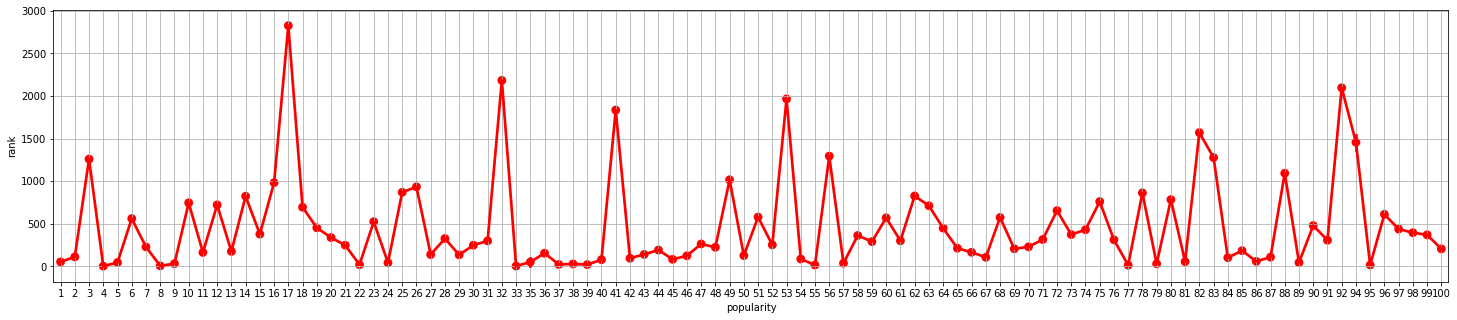

In [15]:
f,ax1 = plt.subplots(figsize =(25,5))
sns.pointplot(x='popularity',y='rank',data=anime_sorted_by_pop,color='red')
plt.grid()

In [17]:
anime_sorted_by_pop[anime_sorted_by_pop["popularity"]==32]

,title,popularity,rank
4825,Highschool of the Dead,32,2184.0


This anime is popular but not well recieved by the users. 

#Genre

In [18]:
anime_genre = anime.genre
anime_genre.head()

0      Comedy, Supernatural, Romance, Shounen
1    Comedy, Parody, Romance, School, Shounen
2               Comedy, Magic, School, Shoujo
3      Comedy, Drama, Magic, Romance, Fantasy
4             Comedy, Drama, Romance, Shounen
Name: genre, dtype: object

In [0]:
genre_list = []

genre_splited = []

for i in anime_genre.index:
    for j in anime_genre[i].split(", "):
        genre_splited.append(j)
        if j not in genre_list:
            genre_list.append(j)        

In [20]:
genre_splited[0:6]

['Comedy', 'Supernatural', 'Romance', 'Shounen', 'Comedy', 'Parody']

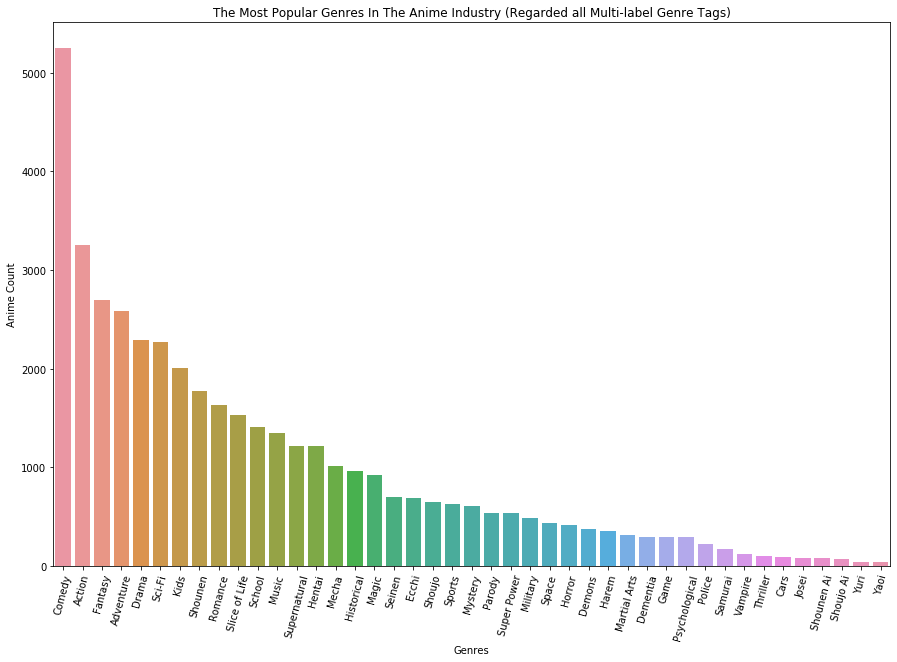

In [25]:
anime_genres_count = pd.Series(genre_splited).value_counts() 

plt.figure(figsize=(15,10))
sns.barplot(x=anime_genres_count.index.tolist(), y=anime_genres_count.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('The Most Popular Genres In The Anime Industry (Regarded all Multi-label Genre Tags)') 
plt.xticks(rotation= 75) 
plt.show()

Most popular genre is comedy. Most anime has multi-genres.

In [0]:
genre_firsts = []

for i in anime_genre.index:
    genre_firsts.append(anime_genre[i].split(", ")[0])

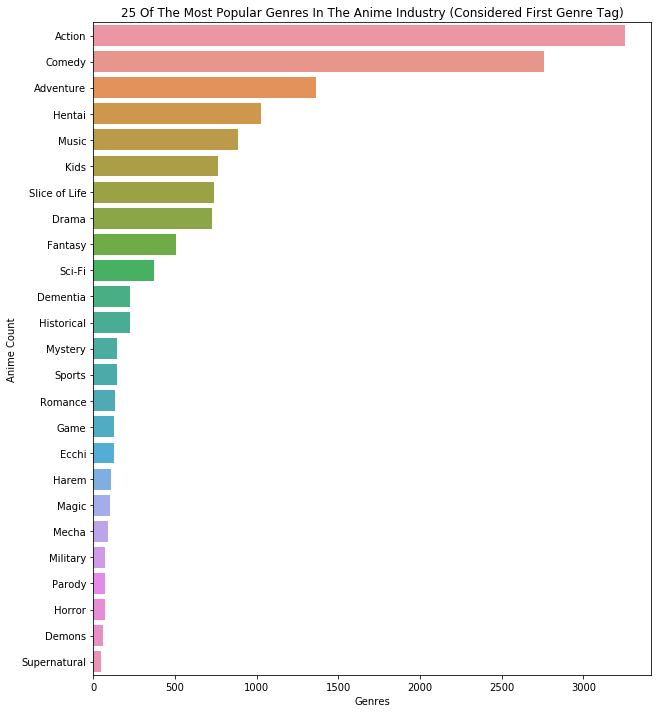

In [27]:
anime_genres_firsts = pd.Series(genre_firsts).value_counts()   

plt.figure(figsize=(10,12))
sns.barplot(x=anime_genres_firsts[0:25].tolist(), y=anime_genres_firsts[0:25].index.tolist())
plt.xlabel('Genres')
plt.ylabel('Anime Count')
plt.title('25 Of The Most Popular Genres In The Anime Industry (Considered First Genre Tag)') 
plt.show()

Action is the genre that is popular with the first genre tag. Most of the time, the genre appear first on the anime is the main focus of the show. 

In [0]:
 # Only 100 k rows are accounted because the system would crash if we did all the rows. 
 # for 43 genre
F = [0]*43
M =   [0]*43

genre_df = pd.DataFrame({'genre': genre_list, 'Female': F, 'Male': M})
genre_df.set_index('genre', inplace=True)

for i in userlists_sub.index:
    for j in userlists_sub.genre[i].split(", "):
        genre_df[userlists_sub.gender[i]][j] +=1 

In [30]:
genre_df.head()

,Female,Male
genre,,
Comedy,11204,38868
Supernatural,5183,16980
Romance,6659,20983
Shounen,5737,20616
Parody,833,3110


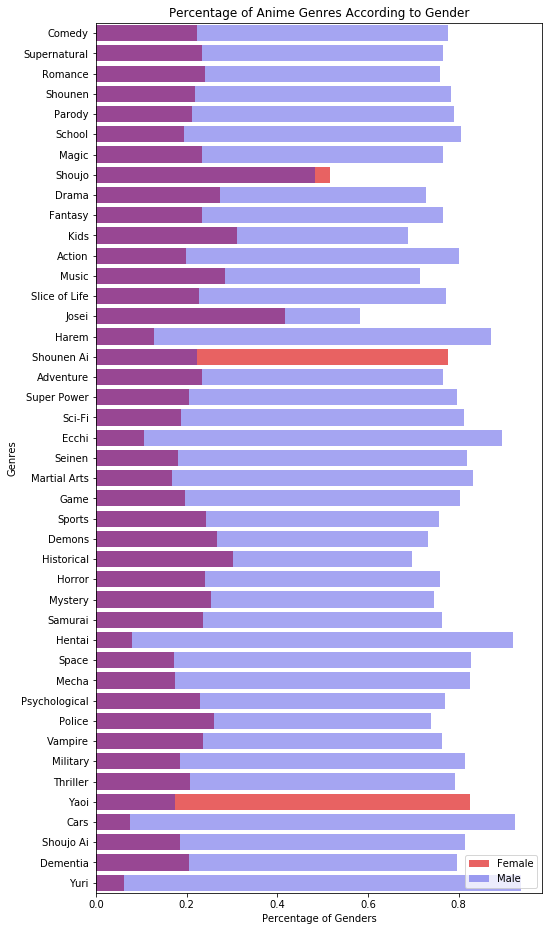

In [31]:
#genre
Female = []
Male = []

for i in genre_list:
    Female.append(genre_df.loc[i,'Female']/sum(genre_df.loc[i,:]))
    Male.append(genre_df.loc[i,'Male']/sum(genre_df.loc[i,:]))  

f,ax = plt.subplots(figsize=(8,16))
sns.barplot(x=Female, y=genre_list, label='Female', color='r', alpha = 0.7)
sns.barplot(x=Male, y=genre_list, label='Male', color='b', alpha = 0.4)

ax.set(xlabel='Percentage of Genders', ylabel='Genres', title='Percentage of Anime Genres According to Gender')
ax.legend(loc='lower right',frameon= True)
plt.show()

You can see there are more male users than female users. Male dominated most of the genre but female dominate some of them.

In [0]:
users['birth_date'] = pd.to_datetime(users['birth_date'], errors = 'coerce')
users=users[users.birth_date.notnull()]

birth_date = users.birth_date
gender = users.gender
spent = users.user_days_spent_watching
 
age = []
for each in birth_date:
    age.append(round((datetime.datetime.now()-each).days/365.25,1))

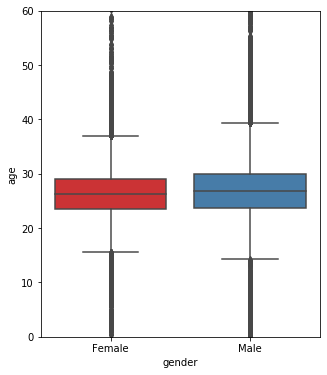

In [33]:
age_dict = {'gender':gender,'age':age,'spent':spent}
users_age_spent = pd.DataFrame(age_dict,columns=['gender','age','spent'])

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5, 6))
sns.boxplot(x="gender", y="age", data=users_age_spent, palette="Set1", ax=ax)
ax.set_ylim([0, 60])
plt.show()

Average users seem to be in their 20's-30's

In [0]:
age.sort()
age[0:5]

#in the first step i dropped obvious outliers

users_age_spent.drop(users_age_spent[users_age_spent.spent>1000].index, inplace=True)
users_age_spent.drop(users_age_spent[users_age_spent.age>80].index, inplace=True)

I drop some users that spend over 1000 days watching anime and users who are over 80. It's not best parameter because it's online. So alot of users could fake their information. 

In [35]:
users_age_spent.head()

,gender,age,spent
0,Female,29.9,55.31
1,Female,25.2,118.07
2,Male,28.6,83.70
3,Male,29.2,167.16
4,Female,21.5,15.20


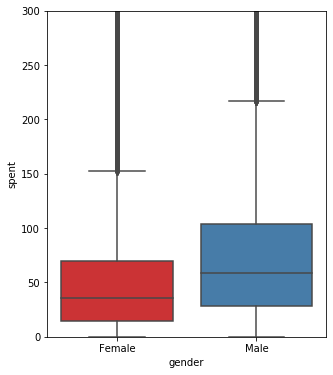

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5, 6))
sns.boxplot(x="gender", y="spent", data=users_age_spent, palette="Set1", ax=ax)
ax.set_ylim([0, 300])
plt.show()

Male users tend to watch more anime on average compare to female. 

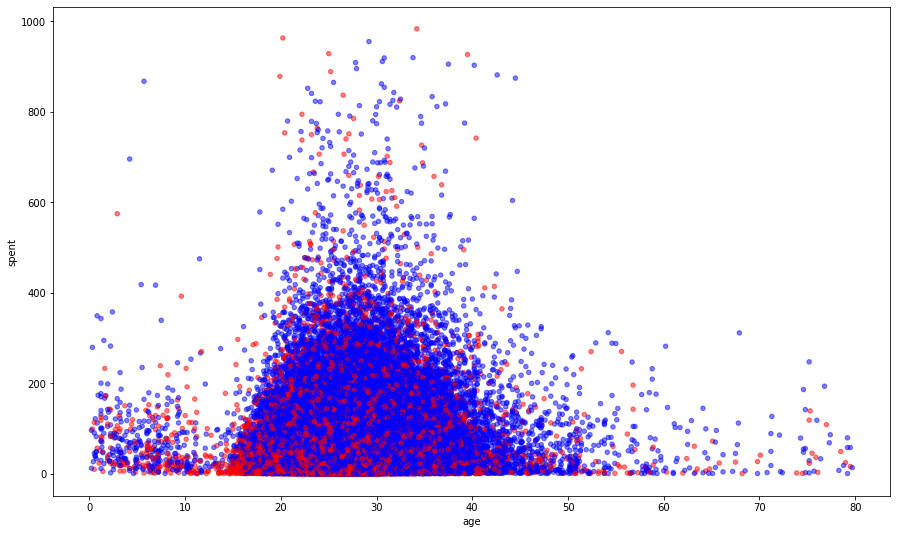

In [37]:
users_age_spent.plot(kind='scatter', x='age', y='spent', alpha=0.5, figsize = (15,9),
                     color=["r" if each =="Female" else "b" for each in users_age_spent.gender])
plt.show()

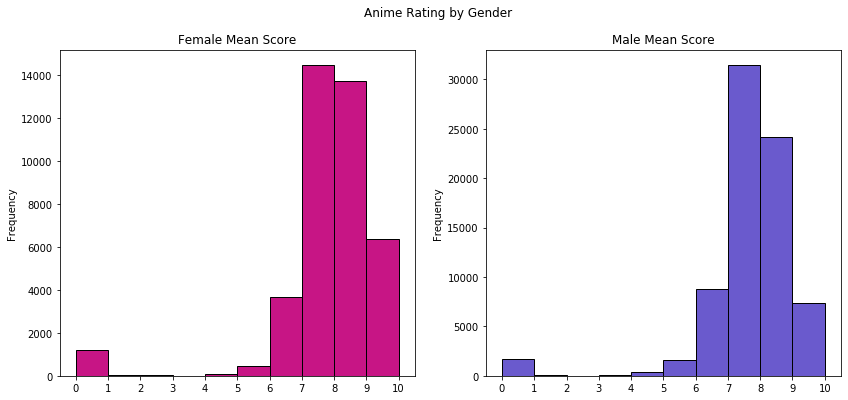

In [38]:
F_stats = df_users[(df_users["gender"]=='Female') & (df_users["stats_episodes"]>=0)].loc[:,["stats_rewatched","stats_mean_score"]]     
M_stats = df_users[(df_users["gender"]=='Male') & (df_users["stats_episodes"]>=0)].loc[:,["stats_rewatched","stats_mean_score"]]    

f,ax=plt.subplots(1,2,figsize=(14,6))
F_stats.stats_mean_score.plot.hist(ax=ax[0],bins=10,edgecolor='black',color='mediumvioletred')
ax[0].set_title('Female Mean Score')
x1=list(range(0,11,1))
ax[0].set_xticks(x1)
M_stats.stats_mean_score.plot.hist(ax=ax[1],bins=10,edgecolor='black',color='slateblue')
ax[1].set_title('Male Mean Score')
x2=list(range(0,11,1))
ax[1].set_xticks(x2)
plt.suptitle('Anime Rating by Gender')
plt.show()

Look like female users tend to score higher than male users but both look like the distribution is about the same with normalization.

# Season

In [0]:
anime_premiered = df_anime[df_anime.premiered.notnull()].premiered
release_seasons = []

for i in anime_premiered.index:
    release_seasons.append(anime_premiered[i].split(" ")[0])

apc = pd.Series(release_seasons).value_counts()   
anime_premiered_count = pd.DataFrame({'season':apc.index, 'premier':apc.values, 'order':[1,3,4,2]})
anime_premiered_count.set_index('order', inplace=True)
anime_premiered_count.sort_index(inplace=True)

In [40]:
anime_premiered_count

,season,premier
order,,
1,Spring,1420
2,Summer,683
3,Fall,1211
4,Winter,782


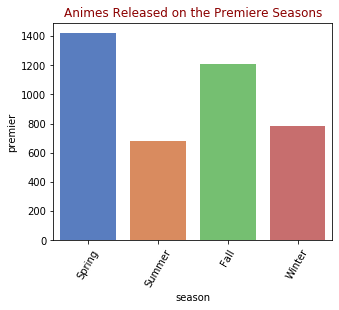

In [41]:
plt.figure(figsize=(5,4))
sns.barplot(x='season',y='premier', data=anime_premiered_count, palette="muted")
plt.xticks(rotation=60)
plt.title('Animes Released on the Premiere Seasons',color = 'darkred',fontsize=12)
plt.show()

Anime releasing in Spring time is the most frequent while Summer is the lowest.

In [0]:
anime_premiered = df_anime[df_anime.premiered.notnull()].premiered
premier_seasons = []
premier_years = []


for i in anime_premiered.index:
    if(2009 <= int(anime_premiered[i].split(" ")[1]) <= 2018):
        premier_seasons.append(anime_premiered[i].split(" ")[0])
        premier_years.append(anime_premiered[i].split(" ")[1])
        
premier_df = pd.DataFrame({
                            'Year':premier_years,
                            'Spring': [1 if each == 'Spring' else 0 for each in premier_seasons],
                            'Summer': [1 if each == 'Summer' else 0 for each in premier_seasons],
                            'Fall':   [1 if each == 'Fall'   else 0 for each in premier_seasons],
                            'Winter': [1 if each == 'Winter' else 0 for each in premier_seasons],
                            })

premier_years_seasons = premier_df.groupby(['Year'])['Spring','Summer','Fall','Winter'].agg('sum')

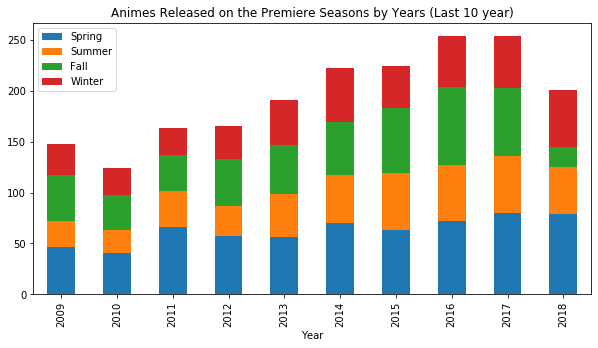

In [44]:
premier_years_seasons.plot(kind='bar',stacked=True, figsize=(10,5), title='Animes Released on the Premiere Seasons by Years (Last 10 year)')
plt.show()

In [0]:
animesources= df_anime['source'].value_counts(dropna=False)
animesources = animesources[animesources.index != 'Unknown']

In [46]:
animesources.head(5)

Original        3367
Manga           3119
Visual novel     887
Game             607
Light novel      563
Name: source, dtype: int64

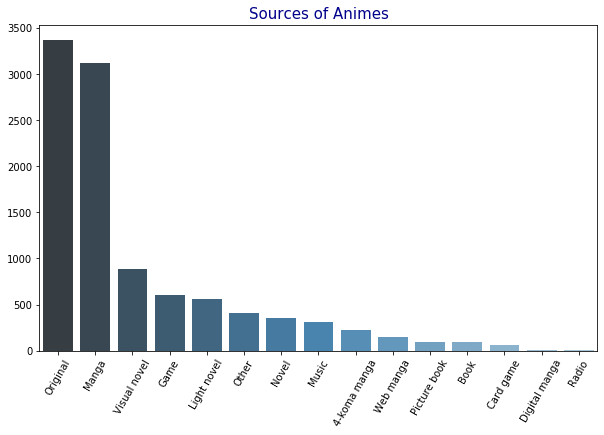

In [47]:
plt.figure(figsize=(10,6))
sns.barplot(x=animesources.index,y=animesources.values, palette="Blues_d")
plt.xticks(rotation=60)
plt.title('Sources of Animes',color = 'darkblue',fontsize=15)
plt.show()

Anime that is original is the highest. Second is manga. Manga is like Japanese comics.

In [0]:
location = [x.split(",")[1].strip() if len(x.split(",")) > 1 else x.split(",")[0].strip() for x in df_users["location"].astype("str")]

In [49]:
pd.Series(location).value_counts()[:5] 

Poland        3755
California    2947
Germany       2250
Canada        2223
Brazil        2071
dtype: int64

In [0]:
location = ["USA" if x in ("USA", "United States of America", "U.S.A.", "US", "U.S.", "U.S.A", 
                           "usa", "United States", "California", "Texas", "New York", "Florida", 
                           "Ohio", "Michigan", "Illinois", "Washington", "Pennsylvania", "Virginia", 
                           "Arizona", "Maryland", "Tennessee",  "New Jersey", "North Carolina", 
                           "Colorado", "Oregon", "Indiana", "Massachusetts", "Minnesota", "NY", "CA", 
                           "TX", "FL", "PA", "IL", "MA", "NC", "NJ", "AZ", "GA", "VA", "IN","TN", 
                           "MI", "SC", "MN", "NYC", "MD", "MO", "WI", "Tx", "CT", "NV", "OR", "KY", 
                           "OH", "Ca", "CO", "LA", "DC", "AL", "ny", "NH", "Philadelphia", "north carolina", 
                           "Missouri", "Nevada", "Kentucky", "Louisiana", "Connecticut", "california", 
                           "Oklahoma", "Alabama", "Hawaii", "Kansas", "Utah", "Iowa", "South Carolina", 
                           "Arkansas", "Nebraska", "texas", "Southern California", "New England", 
                           "Mississippi", "florida", "new york", "Idaho", "New Mexico", "Chicago", 
                           "New Hampshire", "Los Angeles", "Rhode Island", "New York City", "Maine", 
                           "America", "Alaska", "Delaware", "Northern Ireland", "ohio", "Seattle", 
                           "West Virginia", "North Dakota", "South Dakota", "Boston", "Vermont", "Montana", 
                           "michigan", "washington", "New york", "Las Vegas", "Wisconsin", 
                           "Washington State", "SoCal")  else x for x in location]
location = ["UK" if x in ("England", "england", "United Kingdom", "Scotland", "Glasgow", "London", "london", 
                          "Wales", "Manchester", "Nottingham", "Kent", "England.", "united kingdom", "Essex", 
                          "UK", "Uk", "uk", "Britain", "Liverpool", "Birmingham") else x for x in location]
location = ["Netherlands" if x in ("Netherlands", "The Netherlands", "Nederland", "Netherland", "the Netherlands", 
                                   "The netherlands", "netherlands", "Holland", "Amsterdam", "Utrecht", "Rotterdam", 
                                   "Limburg", "the netherlands", "Zuid-Holland") else x for x in location]
location = ["Canada" if x in ("Canada", "canada", "CANADA", "Ontario", "ON", "Quebec", "Québec", "Alberta", 
                              "Toronto", "Vancouver", "British Columbia", "Saskatchewan", "ontario", "BC", 
                              "Montreal", "Manitoba", "Nova Scotia") else x for x in location]
location = ["Brazil" if x in ("Brazil", "Brasil", "São Paulo", "Sao Paulo", "São Paulo - Brazil", "Paraná", 
                              "Pará", "Rio de Janeiro", "RJ", "RS", "SP", "MG", "DF", "Porto Alegre", 
                              "Minas Gerais", "brasil", "Brasil.", "Rio Grande do Sul", "Santa Catarina", 
                              "Bahia", "Ceará", "Pernambuco", "Brazil.", "brazil", 
                              "Goiás") else x for x in location]
location = ["Russia" if x in ("Russia", "Moscow", "Russian Federation", "Saint-Petersburg", "St. Petersburg", 
                              "Saint Petersburg", "Novosibirsk", "Россия", 
                              "St.Petersburg") else x for x in location]
location = ["Japan" if x in ("Japan", "japan", "Tokyo", "tokyo", "Ikebukuro", "Kyoto", 
                             "Osaka") else x for x in location]
location = ["Turkey" if x in ("Turkey", "Istanbul", "İstanbul", "istanbul", "Ankara", "Bursa", "Türkiye", 
                              "Turkiye", "turkey", 
                              "İzmir", "Izmir", "Antalya", "TURKEY") else x for x in location]
location = ["Philippines" if x in ("Philippines", "philippines", "Manila", "Cavite", "Phillipines", 
                                   "Metro Manila", "manila", "Cebu", "Laguna", 
                                   "Quezon City") else x for x in location]
location = ["Indonesia" if x in ("Indonesia", "Jakarta", "indonesia", "Bandung", "West Java", "Central Java", 
                                 "jakarta", "Jawa Timur", "Banten", "Jawa Barat", "East Java", "Indonesian", 
                                 "Yogyakarta") else x for x in location]
location = ["Spain" if x in ("Spain", "España", "Barcelona", "Madrid", "Valencia", 
                             "Catalonia") else x for x in location]
location = ["Poland" if x in ("Poland", "poland", "Warsaw", "Warszawa", "Poznań", "Łódź", "Gdańsk", "Wrocław", 
                              "Kraków", "Cracow", "Szczecin", "Gdynia", "Bydgoszcz", "Lublin", "Białystok", 
                              "Katowice", "Rzeszów", "Lodz") else x for x in location]
location = ["France" if x in ("France", "Paris", "france", "paris", "FRANCE") else x for x in location]
location = ["Australia" if x in ("Australia", "australia", "Sydney", "Melbourne", "Victoria", "WA", "NSW",
                                 "Western Australia", "New South Wales", "Adelaide", "Queensland", "Perth",
                                 "South Australia", "Brisbane") else x for x in location]
location = ["Portugal" if x in ("Portugal", "Lisbon", "Porto", "Lisboa", "portugal") else x for x in location]
location = ["Italy" if x in ("Italy", "Italia", "italy", "Rome", "Roma", "italia") else x for x in location]
location = ["Mexico" if x in ("Mexico", "México", "Mexico City", "mexico", "Baja California", 
                              "Jalisco") else x for x in location]
location = ["Argentina" if x in ("Argentina", "Buenos Aires") else x for x in location]
location = ["Greece" if x in ("Greece", "Athens", "greece", "athens") else x for x in location]
location = ["Hungary" if x in ("Hungary", "Budapest") else x for x in location]
location = ["India" if x in ("India", "india", "INDIA", "Mumbai") else x for x in location]
location = ["Sweden" if x in ("Sweden", "sweden", "Stockholm", "Gothenburg") else x for x in location]
location = ["Latvia" if x in ("Latvia", "Riga") else x for x in location]
location = ["Germany" if x in ("Germany", "Berlin", "Deutschland", "NRW", "Hamburg", "germany", 
                               "Bavaria", "Hessen") else x for x in location]
location = ["Malaysia" if x in ("Malaysia", "malaysia", "Kuala Lumpur", "Selangor", 
                                "Sarawak") else x for x in location]
location = ["Bulgaria" if x in ("Bulgaria", "Sofia") else x for x in location]
location = ["Singapore" if x in ("Singapore", "singapore") else x for x in location]
location = ["Romania" if x in ("Romania", "Bucharest") else x for x in location]
location = ["Austria" if x in ("Austria", "Vienna") else x for x in location]
location = ["Israel" if x in ("Israel", "israel") else x for x in location]
location = ["Lithuania" if x in ("Lithuania", "Vilnius", "Kaunas") else x for x in location]
location = ["Czech Republic" if x in ("Czech Republic", "Czech republic", "Prague") else x for x in location]
location = ["Estonia" if x in ("Estonia", "Tallinn") else x for x in location]
location = ["Ukraine" if x in ("Ukraine", "Kiev", "Odessa") else x for x in location]
location = ["Norway" if x in ("Norway", "Oslo", "norway") else x for x in location]
location = ["Colombia" if x in ("Colombia", "Cali") else x for x in location]
location = ["New Zealand" if x in ("New Zealand", "Auckland", "NZ") else x for x in location]
location = ["Finland" if x in ("New Zealand", "Helsinki") else x for x in location]
location = ["Belgium" if x in ("Belgium", "belgium", "Antwerp") else x for x in location]
location = ["China" if x in ("China", "Hong Kong") else x for x in location]
location = ["Vietnam" if x in ("Vietnam", "Viet Nam") else x for x in location]
location = ["Peru" if x in ("Peru", "Perú", "Lima") else x for x in location]
location = ["Saudi Arabia" if x in ("Saudi Arabia", "Riyadh", "KSA", "K.S.A", "Jeddah", "saudi arabia", 
                                    "jeddah") else x for x in location]
location = ["Kuwait" if x in ("Kuwait", "kuwait") else x for x in location]
location = ["Thailand" if x in ("Thailand", "Bangkok") else x for x in location]
location = ["Bangladesh" if x in ("Bangladesh", "Dhaka", "bangladesh") else x for x in location]
location = ["United Arab Emirates" if x in ("UAE", "Dubai") else x for x in location]
location = ["Ireland" if x in ("Ireland", "Dublin") else x for x in location]
location = ["Chile" if x in ("Chile", "Santiago") else x for x in location]
location = ["Serbia" if x in ("Serbia", "Belgrade") else x for x in location]
location = ["Egypt" if x in ("Egypt", "Cairo") else x for x in location]
location = ["Belarus" if x in ("Belarus", "Minsk") else x for x in location]
location = ["Denmark" if x in ("Denmark", "Copenhagen") else x for x in location]
location = ["South Korea" if x in ("South Korea", "Korea", "Seoul") else x for x in location]
location = ["Croatia" if x in ("Croatia", "Zagreb") else x for x in location]
location = ["Georgia" if x in ("Georgia", "Tbilisi", "georgia") else x for x in location]
#Georgia can be state of America "Georgia" or country "Georgia". I putted it in country category. 
#And i putted GA in state category.
# Use this reference from the user who made the datasets

In [56]:
pd.Series(location).value_counts()[:20] 

USA            20932
Brazil          5337
Poland          4686
UK              4361
Canada          4184
Philippines     2707
Australia       2639
Germany         2505
Russia          2381
Netherlands     2071
Indonesia       1976
France          1763
Portugal        1730
Finland         1554
Sweden          1499
Spain           1246
Italy           1178
Norway           958
Turkey           869
Romania          863
dtype: int64

It's expected that the United States. Since the website is in english =.

In [0]:
loc = pd.Series(location).value_counts()[:25] 

Text(0.5, 1.0, 'Total Members by Country')

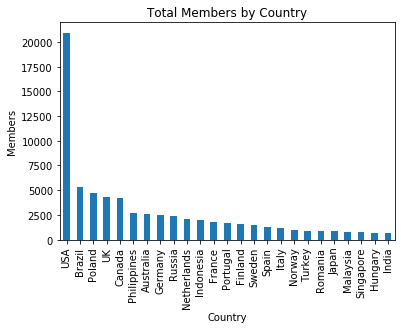

In [72]:
loc.plot(kind='bar')
figsize=(10,6)
plt.ylabel('Members')
plt.xlabel('Country')
plt.title('Total Members by Country')

# Setting up the Data for the Recommendation system

In [0]:
# df_userlists is a huge file of 2gb. Only taking columns that is important for the recommndation system
score_df = df_userlists[['username', 'anime_id', 'my_score', ]]

In [0]:
#Can't have rate anything less than one.
score_df = score_df[score_df.my_score !=0]

In [89]:
#Analysing all the possible values for the score, this will be used as a parameter later on
lower_rating = score_df['my_score'].min()
upper_rating = score_df['my_score'].max()
print('Range of ratings vary between: {0} to {1}'.format(lower_rating, upper_rating))

Range of ratings vary between: 1 to 10


In [0]:
#Counting how many relevant scores each user have done, resetting the index (so the series could become a DF again) and changing the column names
UsersAndScores = score_df['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})

In [91]:
#Taking one percent because anymore will crash the system
UsersSampled = df_users.sample(frac = .01, random_state = 7)
UsersSampled.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
113744,adam1x6,3924291,1,83,0,0,34,25.40,Male,"Pittsburgh, PA",1989-09-25,NaN,2014-07-13,1900-04-15 08:40:00,8.17,0.0,1491.0
92980,GLobalTune,5537957,3,0,0,0,0,0.08,Male,"Holbaek, Denmark",2000-01-28,NaN,2016-07-09,2016-07-15 12:24:00,8.00,0.0,5.0
96809,r0idzipoo,303577,3,110,0,2,133,29.60,Male,"Gilbert,AZ",1993-02-09,NaN,2010-03-11,2015-02-04 17:52:00,8.69,0.0,1681.0
106580,sanjitoshi,5572939,7,194,3,59,46,83.29,Female,"İstanbul, Turkey",1997-11-19,NaN,2016-07-23,1900-05-09 14:20:00,7.61,0.0,5202.0
62510,KanaeShiki,254627,3,324,10,77,78,95.35,Female,"Winnipeg, Manitoba, Canada",1985-02-04,NaN,2009-11-03,1900-03-28 09:39:00,6.18,0.0,6025.0


In [0]:
UsersAndScoresSampled = pd.merge(UsersAndScores, UsersSampled, left_on = 'username', right_on = 'username', how = 'inner')

In [0]:
#Grouping users whom had the same amount of animes rated
UserRatedsAggregated = UsersAndScoresSampled['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated'])

In [94]:
#Counting how many relevant scores each anime has, resetting the index (so the series could become a DF again) and changing the column names
RatedsPerAnime = score_df['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,72602
1,20,55469
2,1575,55462
3,11757,54737
4,16498,54666


In [95]:
#Grouping users whom had the same amount of animes rated
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
0,1,456
1,2,394
2,3,367
3,4,289
4,5,263
5,6,220
6,7,199
7,8,162
8,9,150
9,10,142


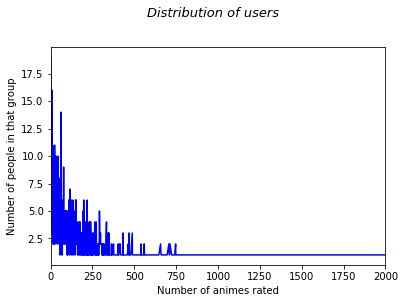

In [96]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.suptitle("Distribution of users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('animes_rated', 'group_size', data = UserRatedsAggregated, color = 'blue')
plt.xlabel('Number of animes rated')
plt.ylabel('Number of people in that group')
plt.xlim(left = 0, right = 2000)
plt.show()

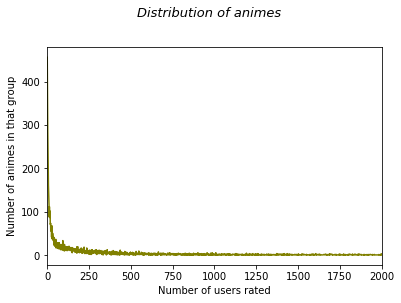

In [97]:
#Creating the plots so we can gather information about the distribution of ratings in the sample
plt.suptitle("Distribution of animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.plot('number_of_users', 'group_size', data = AnimeRatedsAggregated, color = 'olive')
plt.xlabel('Number of users rated')
plt.ylabel('Number of animes in that group')
plt.xlim(left = 0, right = 2000)
plt.show()

In [0]:
#Creating a dataframe of users  and animes with more than 10 interactions
UserRatedsCutten = UsersAndScoresSampled[UsersAndScoresSampled['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]
#Joining (merging) our new dataframes with the interactions one (this will already deal with the sample problem,
#as it is an inner join). The "HotStart" name comes from a pun about solving the "Cold Start" issue
ScoresDFHotStart = pd.merge(score_df, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFHotStart, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')

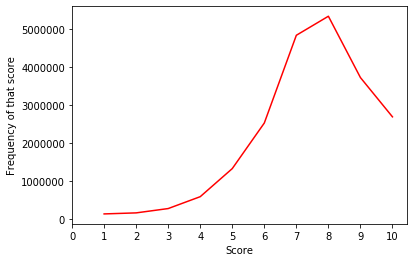

In [99]:
#Grouping the different scores and resetting the index (so the series could become a DF again) 
AnimeRates = score_df['my_score'].value_counts().reset_index().sort_values('index')
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

In [100]:
#Just for the record, lets see the difference in numbers between our initial DF and the sampled and cleaned one

print('The initial dataframe has {0} registers and the sampled one has {1} rows.'.format(score_df['username'].count(), ScoresDFHotStart['username'].count()))

The initial dataframe has 21633401 registers and the sampled one has 221448 rows.


# Training, testing and results

I'm going to build a user-based algorithm and item_based system. I feel like two of them would be a good asset for existing users and new users. I will split the data in a Training and a Test dataset (with a 80/20 proportion). I'm going to use the library Surprise that compare which algothirm is the best by comparing the metrics.  

# Metrics

I'm going to use RMSE and precision. RMSE is gives a high weight to large errors compared to MSE. Precision over recall is ideal because the metric gives importance to items that you actually recommend. the problem with the Recall@k is that I won't be able to recommend all the relevant items since some of my users have 1000 animes scored. 

In [0]:
def precision_recall_at_k(predictions, k=10, threshold= 7):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Creates a dict with the key being a user and the value bringing the estimated rating and the true rating.

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

In [104]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.6MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678237 sha256=81de22a06f4475586715267f0b895836a16d92f13ebde09f94560983e625061f
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import surprise as sp

In [0]:
from scipy.sparse.linalg import svds
from collections import defaultdict
import time

In [128]:
random_state = 7
reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset, testset = sp.model_selection.train_test_split(data, test_size=.25, random_state = random_state)
analysis = defaultdict(list)

test_dict = { 'SlopeOne' : sp.SlopeOne(), 'NMF' : sp.NMF(random_state=random_state), 'NormalPredictor' : sp.NormalPredictor(), 'KNNBaseline' : sp.KNNBaseline(random_state=random_state), 'KNNBasic' : sp.KNNBasic(random_state=random_state), 'KNNWithMeans' : sp.KNNWithMeans(random_state=random_state), 'KNNWithZScore' : sp.KNNWithZScore(random_state=random_state), 'BaselineOnly' : sp.BaselineOnly(), 'CoClustering': sp.CoClustering(random_state=random_state)}

for key, value in test_dict.items():
    start = time.time()    
    value.fit(trainset)
    predictions = value.test(testset)

    rmse = sp.accuracy.rmse(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)

    analysis[value] = (key, rmse, precision_avg, time.time() - start)

print(analysis)

RMSE: 1.2900
RMSE: 2.1737
RMSE: 2.3093
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2569
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.4083
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2837
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2781
Estimating biases using als...
RMSE: 1.2753
RMSE: 1.3189
defaultdict(<class 'list'>, {<surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fefcfd67358>: ('SlopeOne', 1.2899596547058831, 0.93489081567116, 33.0334837436676), <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fefd0d69748>: ('NMF', 2.1736896446623732, 0.9455542557421168, 11.628531455993652), <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7fefd0d694e0>: ('NormalPredictor', 2.3092578952414677, 0.8292477138575391, 0.6623504161834717), <surprise.prediction_algorithms

In [129]:
analysis_df = pd.DataFrame.from_dict(analysis, orient = 'index', columns = ['Algorithm', 'RMSE', 'Precision@10', 'Time to run (in seconds)']).reset_index()

#analysis_df['Algorithm'] = [ 'SlopeOne', 'NMF', 'NormalPredictor', 'KNNBaseline', 'KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'BaselineOnly', 'CoClustering']
analysis_df = analysis_df[['Algorithm', 'RMSE', 'Precision@10', 'Time to run (in seconds)']]
analysis_df = analysis_df.sort_values(by=['Precision@10'], ascending = False)
analysis_df['RMSE^-1'] = analysis_df['RMSE'] ** -1
analysis_df.head(n = 15)

,Algorithm,RMSE,Precision@10,Time to run (in seconds),RMSE^-1
1,NMF,2.173690,0.945554,11.628531,0.460047
7,BaselineOnly,1.275284,0.934954,0.967903,0.784139
0,SlopeOne,1.289960,0.934891,33.033484,0.775218
3,KNNBaseline,1.256897,0.933942,8.944150,0.795610
5,KNNWithMeans,1.283675,0.932722,7.539180,0.779013
6,KNNWithZScore,1.278143,0.931296,8.102930,0.782385
4,KNNBasic,1.408282,0.926211,6.981651,0.710085
8,CoClustering,1.318944,0.923988,4.149548,0.758183
2,NormalPredictor,2.309258,0.829248,0.662350,0.433040


Going to use Baselineonly because it has a lower RMSE than NMF and the precision is less than 0.01. While the RMSE is less than about .9.
It is the simplest algorithm. This is how it works accorrding to the defintion.
" For example, suppose that we want a baseline estimate for the rating of the movie Titanic by user Joe. Now, say that the average rating over all movies, μ, is 3.7 stars. Furthermore, Titanic is better than an average movie, so it tends to be rated 0.5 stars above the average. On the other hand, Joe is a critical user, who tends to rate 0.3 stars lower than the average. Thus, the baseline estimate for Titanic’s rating by Joe would be 3.9 stars by calculating 3.7 − 0.3 + 0.5. "

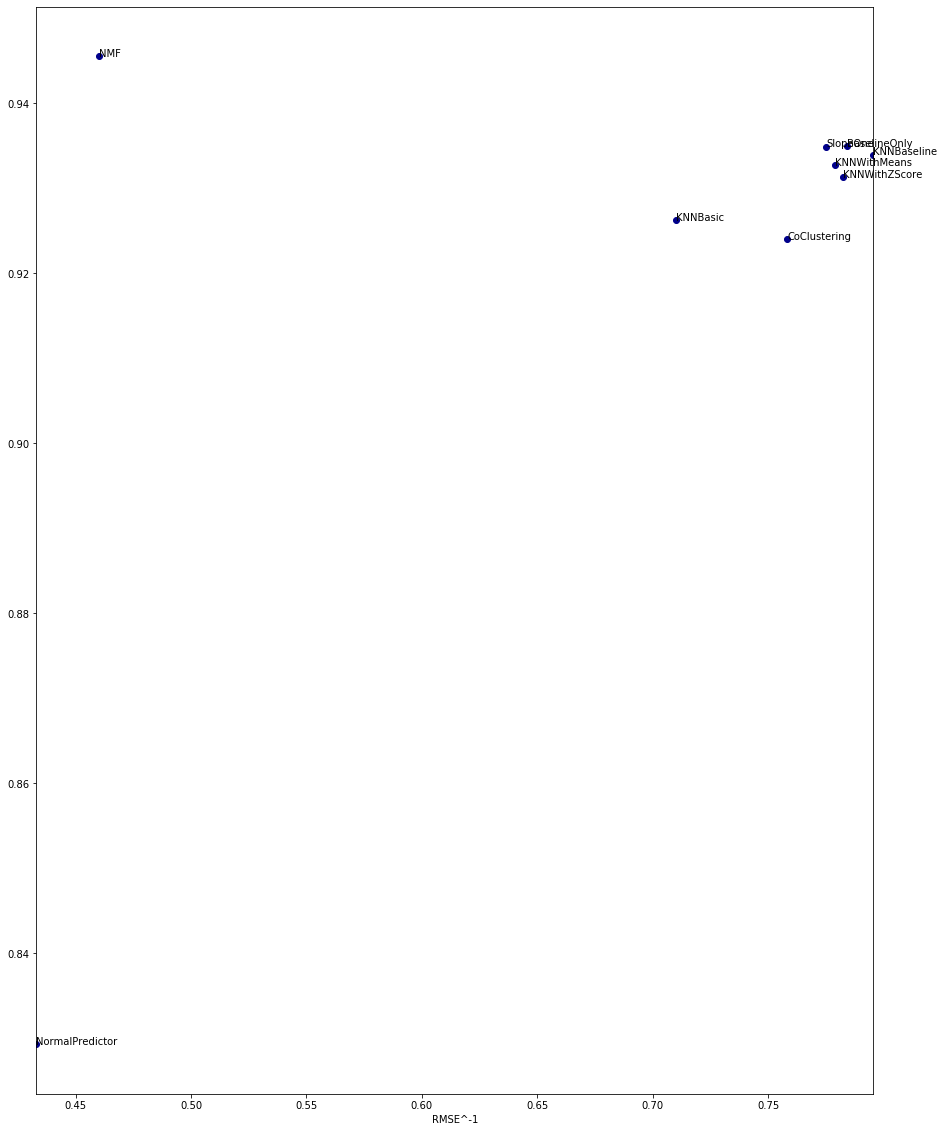

In [131]:
#Show the graph of the scores
ax = analysis_df.set_index('RMSE^-1')['Precision@10'].plot(style='o', c = 'DarkBlue', figsize = (15, 20))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(analysis_df['RMSE^-1'], analysis_df['Precision@10'], analysis_df['Algorithm'], ax)

In [0]:
als_param_grid = {'bsl_options': {'method': ['als'],
                              'reg_i': [5, 10, 15],
                              'reg_u': [10, 15, 20],
                              'n_epochs': [5, 10, 15, 20]
                              }
              }

sgd_param_grid = {'bsl_options': {'method': ['sgd'],
                              'reg': [0.01, 0.02, 0.03],
                              'n_epochs': [5, 10, 15, 20],
                              'learning_rate' : [0.001, 0.005, 0.01]
                              }
              }

als_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, als_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

sgd_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, sgd_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

In [118]:
als_gs.fit(data)

# best RMSE score
print(als_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(als_gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [119]:
sgd_gs.fit(data)

# best RMSE score
print(sgd_gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(sgd_gs.best_params['rmse'])

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimati

sgd is the better option but the error is .001 difference. I'm not gonna change anything.

In [120]:
trainset = data.build_full_trainset()
algo = sp.BaselineOnly()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions.drop('rui', inplace = True, axis = 1)

Estimating biases using als...


In [0]:
def bringing_first_n_values(df, uid, n=10):
    df = df[df['uid'] == uid].nlargest(n, 'est')[['uid', 'iid', 'est']]
    df = pd.merge(df, df_anime, left_on = 'iid', right_on = 'anime_id', how = 'left')
    return df[['uid', 'est', 'title', 'genre', 'premiered']]

In [142]:
bringing_first_n_values(last_predictions, 'adam1x6')

,uid,est,title,genre,premiered
0,adam1x6,9.138323,Ginga Eiyuu Densetsu,"Military, Sci-Fi, Space, Drama",NaN
1,adam1x6,9.104904,Owarimonogatari 2nd Season,"Comedy, Mystery, Supernatural, Vampire",Summer 2017
2,adam1x6,9.100998,Gintama&#039;,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Spring 2011
3,adam1x6,9.075769,Made in Abyss,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",Summer 2017
4,adam1x6,9.059361,Kimi no Na wa.,"Supernatural, Drama, Romance, School",NaN
5,adam1x6,9.054259,3-gatsu no Lion 2nd Season,"Drama, Game, Seinen, Slice of Life",Fall 2017
6,adam1x6,9.016938,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",Spring 2015
7,adam1x6,9.004694,Kizumonogatari III: Reiketsu-hen,"Action, Mystery, Supernatural, Vampire",NaN
8,adam1x6,8.993671,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",Fall 2012
9,adam1x6,8.969301,Mushishi Zoku Shou 2nd Season,"Adventure, Fantasy, Historical, Mystery, Seine...",Fall 2014


In [143]:
bringing_first_n_values(last_predictions, 'r0idzipoo')

,uid,est,title,genre,premiered
0,r0idzipoo,9.991368,Fullmetal Alchemist: Brotherhood,"Action, Military, Adventure, Comedy, Drama, Ma...",Spring 2009
1,r0idzipoo,9.934125,Steins;Gate,"Thriller, Sci-Fi",Spring 2011
2,r0idzipoo,9.885846,Ginga Eiyuu Densetsu,"Military, Sci-Fi, Space, Drama",NaN
3,r0idzipoo,9.852426,Owarimonogatari 2nd Season,"Comedy, Mystery, Supernatural, Vampire",Summer 2017
4,r0idzipoo,9.848521,Gintama&#039;,"Action, Sci-Fi, Comedy, Historical, Parody, Sa...",Spring 2011
5,r0idzipoo,9.823291,Made in Abyss,"Sci-Fi, Adventure, Mystery, Drama, Fantasy",Summer 2017
6,r0idzipoo,9.806884,Kimi no Na wa.,"Supernatural, Drama, Romance, School",NaN
7,r0idzipoo,9.801782,3-gatsu no Lion 2nd Season,"Drama, Game, Seinen, Slice of Life",Fall 2017
8,r0idzipoo,9.764460,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",Spring 2015
9,r0idzipoo,9.752216,Kizumonogatari III: Reiketsu-hen,"Action, Mystery, Supernatural, Vampire",NaN


This is an item-based recommender.

In [127]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo_items = sp.KNNBaseline(sim_options=sim_options)
algo_items.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
def get_item_recommendations(anime_title, anime_id=100000, k=10):
    if anime_id == 100000:     
        anime_id = df_anime[df_anime['title'] == anime_title]['anime_id'].iloc[0]
        
    iid = algo_items.trainset.to_inner_iid(anime_id)
    neighbors = algo_items.get_neighbors(iid, k=k)
    raw_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors)
    df = pd.DataFrame(raw_neighbors, columns = ['Anime_ID'])
    df = pd.merge(df, df_anime, left_on = 'Anime_ID', right_on = 'anime_id', how = 'left')
    return df[['Anime_ID', 'title', 'genre', 'score', 'premiered']]

In [138]:
get_item_recommendations('One Piece', k=30)

,Anime_ID,title,genre,score,premiered
0,11061,Hunter x Hunter (2011),"Action, Adventure, Super Power, Shounen",9.11,Fall 2011
1,15,Eyeshield 21,"Action, Sports, Comedy, Shounen",8.05,Spring 2005
2,6702,Fairy Tail,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",8.08,Fall 2009
3,16498,Shingeki no Kyojin,"Action, Military, Mystery, Super Power, Drama,...",8.49,Spring 2013
4,1604,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",8.31,Fall 2006
5,235,Detective Conan,"Adventure, Mystery, Comedy, Police, Shounen",8.25,Winter 1996
6,18115,Magi: The Kingdom of Magic,"Action, Adventure, Magic, Fantasy, Shounen",8.44,Fall 2013
7,9253,Steins;Gate,"Thriller, Sci-Fi",9.14,Spring 2011
8,170,Slam Dunk,"Comedy, Sports, Drama, School, Shounen",8.55,Fall 1993
9,469,Karin,"Comedy, Romance, Vampire, School, Shounen",7.28,Fall 2005


In [139]:
get_item_recommendations('Berserk', k=30)

,Anime_ID,title,genre,score,premiered
0,34055,Berserk 2nd Season,"Action, Adventure, Demons, Drama, Fantasy, Hor...",7.09,Spring 2017
1,27899,Tokyo Ghoul √A,"Action, Mystery, Horror, Psychological, Supern...",7.45,Winter 2015
2,10620,Mirai Nikki (TV),"Action, Psychological, Supernatural, Thriller,...",7.89,Fall 2011
3,15451,High School DxD New,"Action, Harem, Comedy, Demons, Romance, Ecchi,...",7.79,Summer 2013
4,20785,Mahouka Koukou no Rettousei,"Action, Sci-Fi, Supernatural, Magic, Romance, ...",7.74,Spring 2014
5,10218,Berserk: Ougon Jidai-hen I - Haou no Tamago,"Action, Military, Adventure, Demons, Supernatu...",7.88,NaN
6,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",7.64,Summer 2012
7,6702,Fairy Tail,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",8.08,Fall 2009
8,11111,Another,"Mystery, Horror, Supernatural, Thriller, School",7.77,Winter 2012
9,22319,Tokyo Ghoul,"Action, Mystery, Horror, Psychological, Supern...",8.00,Summer 2014


In [140]:
get_item_recommendations('Slam Dunk', k=30)

,Anime_ID,title,genre,score,premiered
0,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",8.31,Spring 1998
1,263,Hajime no Ippo,"Comedy, Sports, Drama, Shounen",8.80,Fall 2000
2,21,One Piece,"Action, Adventure, Comedy, Super Power, Drama,...",8.54,Fall 1999
3,121,Fullmetal Alchemist,"Action, Adventure, Comedy, Drama, Fantasy, Mag...",8.29,Fall 2003
4,4722,Skip Beat!,"Comedy, Drama, Romance, Shoujo",8.24,Fall 2008
5,889,Black Lagoon,"Action, Seinen",8.13,Spring 2006
6,813,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",8.31,Spring 1989
7,13125,Shinsekai yori,"Sci-Fi, Mystery, Horror, Psychological, Supern...",8.49,Fall 2012
8,11061,Hunter x Hunter (2011),"Action, Adventure, Super Power, Shounen",9.11,Fall 2011
9,15,Eyeshield 21,"Action, Sports, Comedy, Shounen",8.05,Spring 2005


This is results of using KNN model since it score the best for algorthims that can do item-item recommendation. Based on judgement, I would say it is accurate.
Now I'm going to use pyspark to use the ALS algorthim to compare with baseline. It's going to use all the data.